In [4]:
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import gc
from PIL import ImageFile
import torch
import open_clip
from PIL import Image
import concurrent


ImageFile.LOAD_TRUNCATED_IMAGES = True
torch.set_grad_enabled(False)

/Users/fugazi/Fashion/sd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
image_sizes = []
for file in os.listdir('assets'):
    img = Image.open('assets/' + file)
    image_sizes.append(img.size)

In [4]:
from collections import Counter
Counter(image_sizes).most_common()

[((1080, 1440), 307292),
 ((1000, 1333), 60),
 ((1025, 1400), 60),
 ((1440, 1880), 14),
 ((1000, 1500), 12),
 ((1080, 1410), 11),
 ((2160, 2880), 11),
 ((1500, 2098), 9),
 ((1080, 1439), 8),
 ((1500, 2000), 7),
 ((1081, 1440), 6),
 ((1080, 1441), 6),
 ((1080, 1400), 6),
 ((1082, 1440), 5),
 ((1079, 1440), 5),
 ((1200, 1600), 4),
 ((1600, 2400), 4),
 ((1200, 1800), 3),
 ((960, 1280), 3),
 ((2000, 3000), 3),
 ((2160, 2800), 3),
 ((1149, 1532), 2),
 ((2000, 2400), 2),
 ((1079, 1432), 2),
 ((1500, 1940), 2),
 ((1574, 2098), 2),
 ((1064, 1427), 2),
 ((1340, 2009), 2),
 ((1076, 1440), 2),
 ((1150, 1440), 2),
 ((838, 1117), 1),
 ((1085, 1440), 1),
 ((1200, 1599), 1),
 ((768, 1024), 1),
 ((2000, 2000), 1),
 ((1100, 1400), 1),
 ((1080, 1480), 1),
 ((2100, 3300), 1),
 ((887, 1183), 1),
 ((1002, 1335), 1),
 ((1080, 1444), 1),
 ((1009, 1345), 1),
 ((2160, 2878), 1),
 ((1058, 1410), 1),
 ((1940, 2586), 1),
 ((1723, 2498), 1),
 ((844, 1126), 1),
 ((1027, 1370), 1),
 ((1078, 1440), 1),
 ((1960, 2978)

In [1]:
import time

In [2]:
from PIL import Image

def resize_images(files, size=(224, 224)):
    input_folder = 'assets'
    output_folder = 'assets-224-224'
    for file in files:
        img = Image.open(input_folder + '/' + file)
        img = img.resize(size, Image.BICUBIC)
        img.save(output_folder + '/' + file)
        del img


In [6]:
def get_image_files():
    processed = set(os.listdir('assets-224-224'))
    image_files = [x for x in os.listdir('assets') if x not in processed]
    return image_files

def multithreaded_resize_images(num_threads=10, batch_size=200):
    image_files = get_image_files()
    print('received image files')
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        for i in range(0, len(image_files), batch_size):
            executor.submit(resize_images, image_files[i:min(i+batch_size, len(image_files))])

func()
def find_best_thread_params():
    for num_threads in [10, 11, 12, 13]:
        start = time.time()
        func(num_threads)
        end = time.time()

        print(f'{num_threads} Threads: ', end - start)

def test_single_threaded(batch_size=200):
    image_files = get_image_files()
    for i in tqdm(range(0, len(image_files), batch_size)):
        resize_images(image_files[i:min(i+batch_size, len(image_files))])
# test_single_threaded()


received image files


1535

In [25]:
all_image_files = os.listdir('assets')

In [22]:
io_time, compute_time
6s, 195s

(-0.0068264007568359375, -0.19552159309387207)

In [5]:
img = Image.open('assets/' + os.listdir('assets')[0])

(1080, 1440)


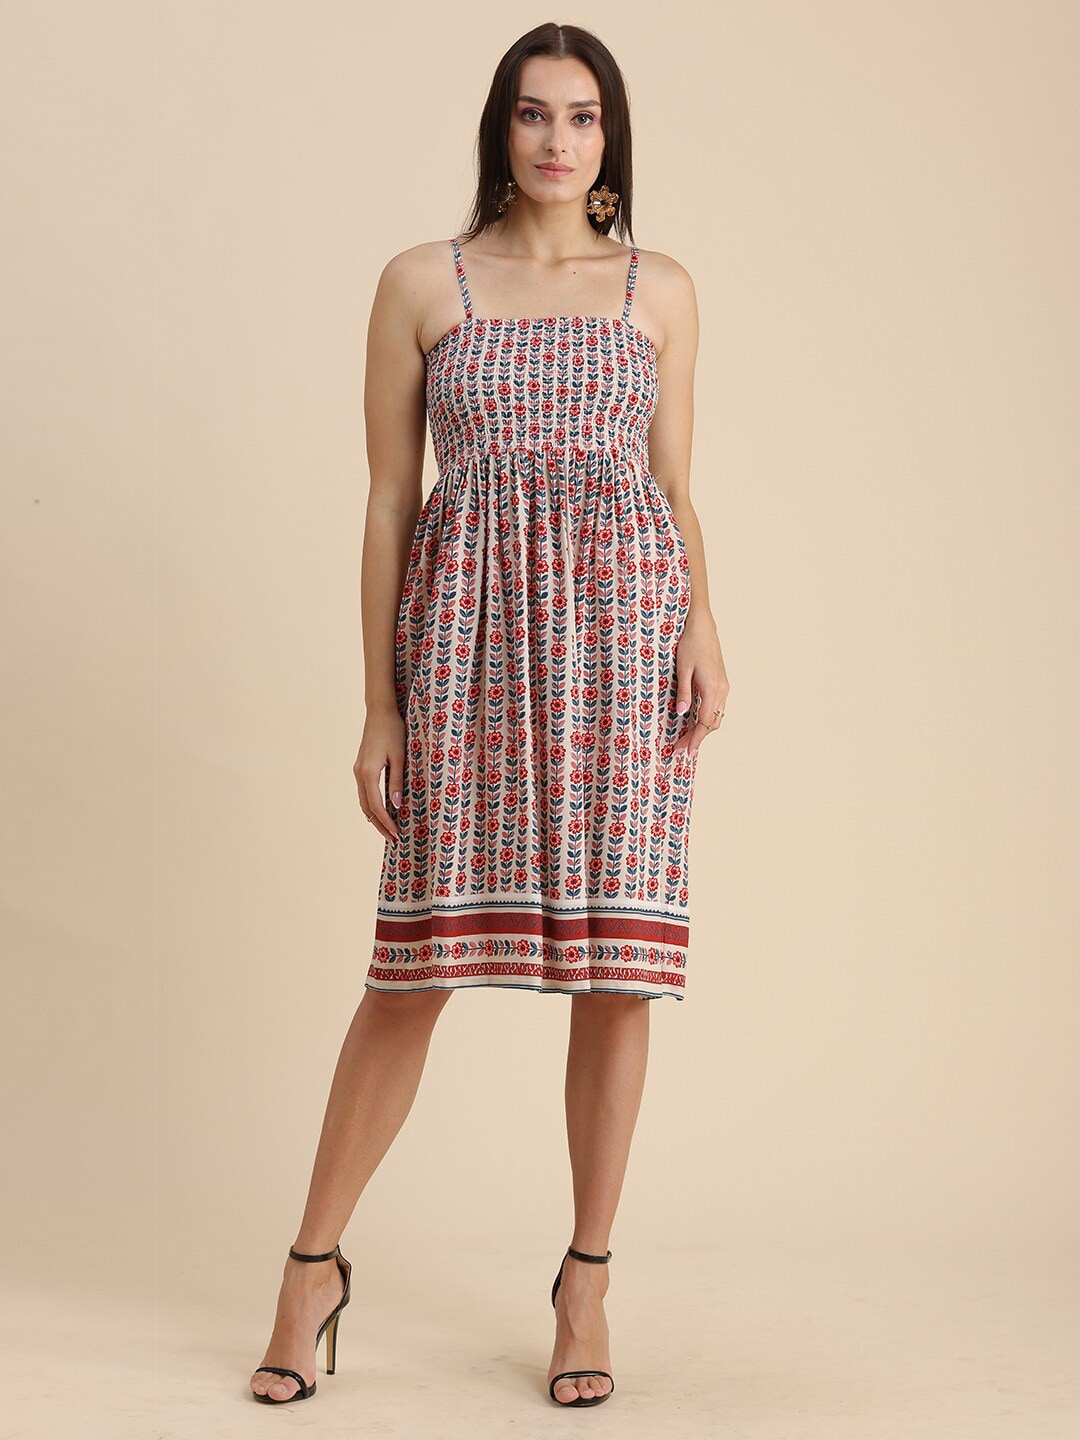

In [7]:
print(img.size)
img

In [9]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')

torch.Size([3, 224, 224])

In [11]:
model.visual.image_size

(224, 224)

In [10]:
preprocess(img).shape

torch.Size([3, 224, 224])

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')

batch_size = 100
all_images_features = []
for i in tqdm(range(0, len(all_images[:20000]), batch_size)):
    batch_images = all_images[i:i+batch_size]
    batch_images = [preprocess(Image.open('assets/' + img_path)).unsqueeze(0) for img_path in batch_images]
    batch_images = torch.cat(batch_images, 0)
    with torch.no_grad():
        batch_features = model.encode_image(batch_images)
    all_images_features.extend(batch_features)
    del batch_images, batch_features  # delete the variables
    gc.collect()

print(all_images_features)

In [ ]:
all_images_features_tensor = torch.stack(all_images_features)
all_images_features_tensor /= all_images_features_tensor.norm(dim=-1, keepdim=True)

def plotKNN(base_embedding, nrow=5, ncol=5, figsize=(10, 10), title=""):
    probs = torch.nn.functional.cosine_similarity(all_images_features_tensor, base_embedding.view(1, 512))

    top_indices = probs.topk(nrow * ncol).indices
    top_images = [all_images[i] for i in top_indices]
    top_scores = probs[top_indices]

    fig, axs = plt.subplots(nrow, ncol, figsize=figsize)
    fig.suptitle(f"{title}", fontsize=20, fontname='Comic Sans MS')
    
    for i, (img, score, ix) in enumerate(zip(top_images, top_scores, top_indices)):
        img_path = 'assets/' + img
        image = Image.open(img_path)
        axs[i//ncol][i%ncol].imshow(image)
        axs[i//ncol][i%ncol].set_title(f"{int(score * 100)/100}, {ix}, {products[ix]['price']}")

        axs[i//ncol][i%ncol].axis('off')

    plt.show()
    for ix in top_indices:
        url = 'https://www.myntra.com/' + products[ix]['landingPageUrl']
        print(f'{ix}\t{url}')

def mashup(image_ixs, nrow=5, ncol=5, figsize=(10, 10)):
    mean_embedding = all_images_features_tensor[torch.tensor(image_ixs)].mean(dim=0)
    mean_embedding /= mean_embedding.norm()

    plotKNN(mean_embedding, nrow, ncol, figsize, title='Mashup :' + str(image_ixs))

def ask(query, nrow=5, ncol=5, figsize=(10, 10)):
    text = tokenizer([query])
    text_features = model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    plotKNN(text_features, nrow, ncol, figsize, title=query)

def similar(image_ix, nrow=5, ncol=5, figsize=(10, 10)):
    base_image_feature = all_images_features_tensor[image_ix]
    base_image_feature /= base_image_feature.norm()
    plotKNN(base_image_feature, nrow, ncol, figsize, title=f'Similar: {image_ix}')

def mashup_all(image_ixs, queries, nrow=5, ncol=5, figsize=(20, 20)):
    image_mean_embedding = all_images_features_tensor[torch.tensor(image_ixs)].mean(dim=0)
    image_mean_embedding /= image_mean_embedding.norm()

    query_embedding = model.encode_text(tokenizer(queries))
    query_embedding /= query_embedding.norm(dim=-1, keepdim=True)
    query_embedding = query_embedding.mean(dim=0)

    final_embedding = torch.stack([image_mean_embedding, query_embedding]).mean(dim=0)
    final_embedding /= final_embedding.norm(dim=0)
    plotKNN(final_embedding, nrow, ncol, figsize, title='Mashup: ' + str(image_ixs) + ', ' + ','.join(queries))

In [ ]:
# ask("work wear tops")
# ask("basic tops", [20, 20])
# similar(14998, figsize=(20, 20))
# similar(16819, figsize=(20, 20))
# mashup_all([14998, 15334, 14552], ['corset top'], figsize=(20, 20))
# similar(7745, figsize=(20, 20))
# mashup_all([14248], ['sunflower pattern'], figsize=(20, 20))
# mashup([7745, 5036], figsize=(20, 20))
# ask("light turtleneck with dark color", figsize=(20, 20))
# ask("sexy fine dine date dress corset top", figsize=(20, 20))
similar(493, figsize= (20, 20))
# ask("casual blazer", figsize=(20, 20))